## Contributions to Consumer Spending Growth by Quintile

From BLS Consumer Expenditure Survey

List of series here: https://download.bls.gov/pub/time.series/cx/cx.series

Based on the accounting identity that after-tax income equals consumer spending plus saving, $Y = C + S$, we can rearrange to view the relationship as:

$C = Y - S$

This relationship is useful because we know that spending is more stable than income.

Additionally, income can come from markets ($MI$ = wages and salaries, self employment income, dividends, interest income, and rental income), or come from other sources ($OI$), primarily government social benefits. 

$C = (MI + OI) - S$, where:

$OI = Y - MI$

and I am interested in the percent change in consumer spending which I approximate as:

$\%\Delta C = \%\Delta MI + \%\Delta OI - \%\Delta S$

All of the values are nominal USD. 

In [203]:
# Import libraries / preliminaries
%config Completer.use_jedi = False
import pandas as pd
import requests
import io, itertools, time
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
plt.rc('axes', edgecolor='white')
plt.rc('ytick',labelsize=8)
plt.rc('xtick',labelsize=8)
plt.rc('legend',fontsize=9)

# Header to retrieve flat files from BLS
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/110.0'}

# Recession start and end months, from NBER
rec_dt = [('1969-12-01', '1970-11-01'), ('1973-11-01', '1975-03-01'), 
          ('1980-01-01', '1980-07-01'), ('1981-07-01', '1982-11-01'),
          ('1990-07-01', '1991-03-01'), ('2001-04-01', '2001-12-01'), 
          ('2008-01-01', '2009-07-01'), ('2020-02-01', '2020-04-01')]

In [2]:
# # Retrieve all CE data from BLS, as flat file
# url = 'https://download.bls.gov/pub/time.series/cx/cx.data.1.AllData'
# r = requests.get(url, headers=headers)
# converters = {'series_id                     ': lambda x: x.strip()}
# df = pd.read_csv(io.StringIO(r.content.decode('utf-8')), sep='\t', 
#                   converters=converters)
# df.columns = df.columns.str.strip()
# full = df.set_index('series_id').drop(['footnote_codes', 'period'], 
#                                       axis=1)
# full.to_csv('ce_full.csv')

In [69]:
# Read local csv file
df = pd.read_csv('ce_full.csv')
df.loc[df.value == '           -', 'value'] = None
df = df.dropna()

# Variables
cats = ['TOTALEXP', 'INCAFTTX', 'INCBEFTX', '900000', 'SFEMPINC', 
        'INDIVRNT', 'PENSIONS']

# Income quintiles (and total == 1)
grps = [1, 2, 3, 4, 5, 6]

levels, contrib = {}, {}
for grp in grps:
    dft = pd.DataFrame()
    for cat in cats:
        name = f'CXU{cat}LB010{grp}M'
        s = df.loc[df.series_id == name] 
        dft[cat] = s.set_index('year')['value'].astype('int')
    dft = dft.rename({'900000': 'Wages'}, axis=1)
    # Self employment not significant for bottom quintile in 2022, set to 0
    if grp == 2:
        dft.loc[2022, 'SFEMPINC'] = 0
    dft['Spending'] = (dft['TOTALEXP'] - dft['PENSIONS']) # Remove SS/Pension
    dft['Market Income'] = (dft['Wages'] + dft['SFEMPINC'] + dft['INDIVRNT'])
    dft['Other Income & Taxes'] = (dft['INCAFTTX'] - dft['Market Income'])
    sname = 'Saving (-) / Dis-saving or Borrowing (+)'
    dft[sname] = (dft['Spending'] - dft['INCAFTTX'])
    levels[grp] = dft # Return result in levels (nominal USD)
    ch = dft.diff()
    ch = ch.div(ch['Spending'], axis=0)
    ch = ch.multiply(dft['Spending'].pct_change() * 100, axis=0)
    contrib[grp] = ch # Each category's contribution to spending growth

### Main Summary Chart

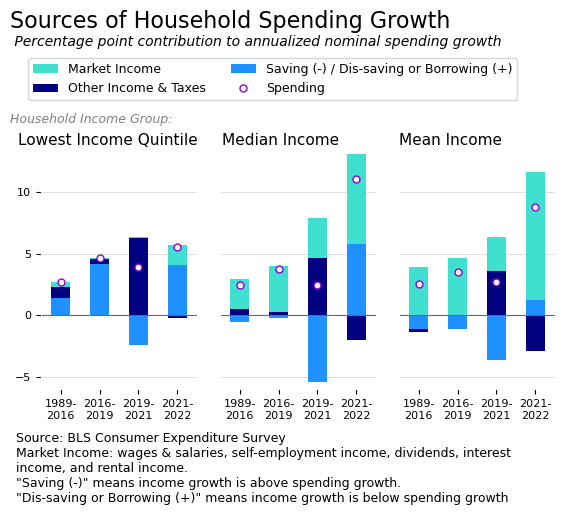

In [333]:
# Chart 1
slist = ['Saving (-) / Dis-saving or Borrowing (+)', 
         'Other Income & Taxes', 'Market Income', 'Spending']
ylist = [(1989, 2016), (2016, 2019), (2019, 2021), (2021, 2022)]
groups = [2, 4, 1]
b10, m10, t10 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for year1, year2 in ylist:
    adj = year2 - year1
    dt = f'{year1}-\n{year2}'
    res = {}
    for grp, fr in zip(groups, [b10, m10, t10]):
        dft = levels[grp]
        ch = (dft.loc[year2] - dft.loc[year1])
        chsh = ch / ch.Spending
        spg = ((dft.loc[year2, 'Spending'] / 
                dft.loc[year1, 'Spending']) ** (1/adj) - 1) * 100
        chc = spg * chsh
        fr[dt] = (chc[slist])
        
colors=['dodgerblue', 'navy', 'turquoise', 'darkviolet']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5.8, 3))
plt.tight_layout()
yticks = [-5, 0, 5, 10]
for ax, fr in zip([ax1, ax2, ax3], [b10, m10, t10]):
    fr.T[slist[:-1]].plot(kind='bar', stacked=True, ax=ax, 
                          legend=False, color=colors[:-1])
    fr.T['Spending'].plot(marker='.', ax=ax, markersize=10,
                          mec='darkviolet',
                          color='white', ls='')
    ax.set_ylim(-6.0, 14)
    ax.axhline(0, color='dimgray', lw=0.8)
    ax.set_yticks([])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    for xv in yticks:
        ax.axhline(xv, color='lightgray', lw=0.5, zorder=0)
ax1.set_yticks(yticks)
ax1.text(-1.1, 13.8, 'Lowest Income Quintile', size=11)
ax1.text(-1.3, 15.6, 'Household Income Group:', size=9, style='italic', 
         color='gray')
ax2.text(-0.45, 13.8, 'Median Income', size=11)
ax3.text(-0.5, 13.8, 'Mean Income', size=11)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(reversed(handles), reversed(labels), 
           bbox_to_anchor=(3.1, 1.37), ncol=2)
plt.subplots_adjust(wspace=0.15)
title = ('Sources of Household Spending Growth')
subtitle = (f' Percentage point contribution to annualized nominal '+
            'spending growth')
fig.text(0.02, 1.32, title, fontsize=16)
fig.text(0.02, 1.26, subtitle, fontsize=10, style='italic')
footer = ('Source: BLS Consumer Expenditure Survey\n'+
          'Market Income: wages & salaries, self-employment income, '+
          'dividends, interest\nincome, and rental income.\n'+
          '"Saving (-)" means income growth is above spending growth.\n'+
          '"Dis-saving or Borrowing (+)" means income growth is below '+
          'spending growth')
fig.text(0.03, -0.26, footer, fontsize=9)
plt.savefig('summary.png', bbox_inches='tight')
plt.show()

### Chart Time Series

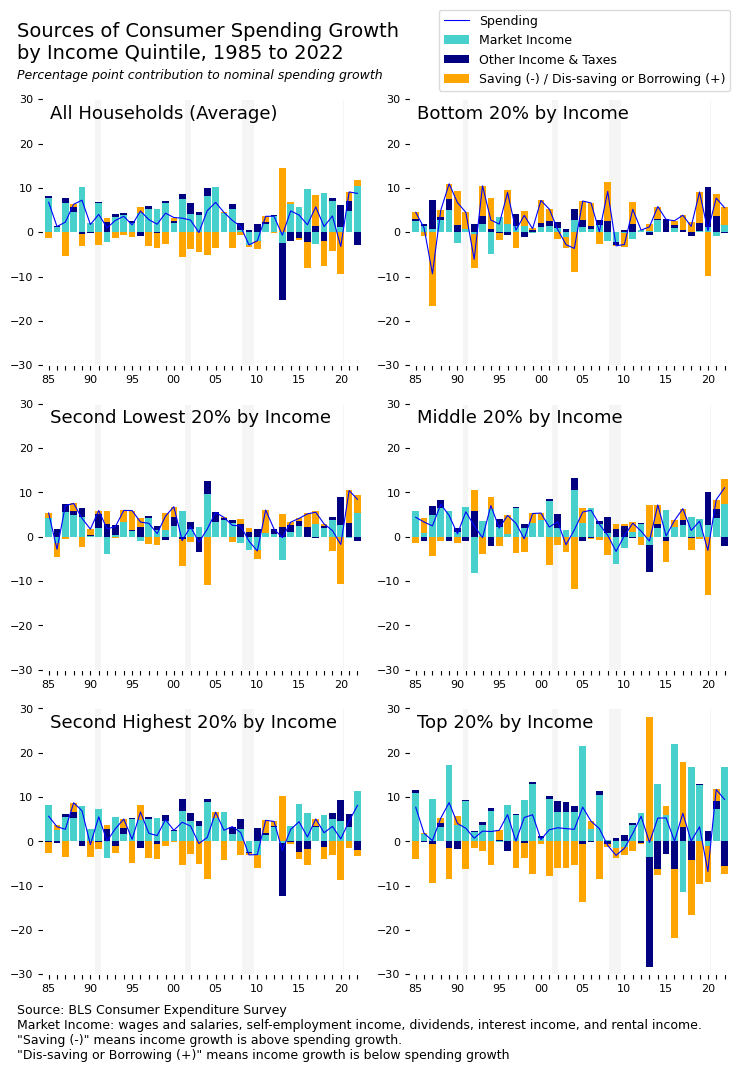

In [334]:
# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(7.5, 10))
axs = axs.flatten() # Flatten for easy iteration

# Contribution categories
srs = ['Market Income', 'Other Income & Taxes', 
       'Saving (-) / Dis-saving or Borrowing (+)']
# Quintile/Group names
names = {1: 'All Households (Average)', 2: 'Bottom 20% by Income', 
         3: 'Second Lowest 20% by Income', 4: 'Middle 20% by Income', 
         5: 'Second Highest 20% by Income', 6: 'Top 20% by Income'}

# Loop through the dictionary and plot each DataFrame
for i, (key, df) in enumerate(contrib.items()):
    df = df.loc['1985':]
    xticks = [str(year)[2:] if year % 5 == 0 else '' for year in df.index]
    df.index = [pd.to_datetime(f'{year}-07-01') for year in df.index]
    df.index.name = ''   
    # Stacked bar chart for contributions
    df[srs].plot(kind='bar', stacked=True, ax=axs[i], width=0.8, 
                 color=['mediumturquoise', 'navy', 'orange'])
    # Line for spending
    df['Spending'].plot(color=['blue'], ax=axs[i], lw=0.8, use_index=False)
    axs[i].text(0.02, 0.98, f'{names[key]}', va='top', size=13, 
                transform=axs[i].transAxes) # Subplot title
    #axs[i].set_title(f'{names[key]}', size=14)  # Subplot title
    axs[i].set_xticklabels(xticks)
    axs[i].set_ylim(-30, 30)
    # Recession bars
    for start, end in rec_dt:
        st = (pd.to_datetime(start) - df.index[0]).days / 365
        en = (pd.to_datetime(end) - df.index[0]).days / 365
        axs[i].axvspan(st+0.6, en+0.6, facecolor='whitesmoke', zorder=0)
    # Legend on one chart and moved to above chart
    if i != 1:
        axs[i].get_legend().remove()
    if i == 1:
        axs[i].legend(edgecolor='lightgray', bbox_to_anchor=(1.02, 1.36), 
                      loc='upper right', fontsize=9)
    
# Figure title and footer
title = ('Sources of Consumer Spending Growth\nby Income Quintile, 1985 to 2022')
subtitle = ('Percentage point contribution to nominal '+
            'spending growth')
fig.text(0.03, 0.95, title, fontsize=14)
fig.text(0.03, 0.93, subtitle, fontsize=9, style='italic')
footer = ('Source: BLS Consumer Expenditure Survey\n'+
          'Market Income: wages and salaries, self-employment income, '+
          'dividends, interest income, and rental income.\n'+
          '"Saving (-)" means income growth is above spending growth.\n'+
          '"Dis-saving or Borrowing (+)" means income growth is below '+
          'spending growth')
fig.text(0.03, -0.05, footer, fontsize=9)    
# Adjust layout
plt.tight_layout(w_pad=-1)
plt.savefig('Spending.jpg')
plt.show()

### Summary of growth between years

In [5]:
def summary_bars(levels_df, year1, year2):
    adj = year1 - year2
    ann = ''
    if adj > 1:
        ann = 'annualized '

    # Gather data for bar charts
    slist = ['Saving (-) / Dis-saving or Borrowing (+)', 
             'Other Income & Taxes', 'Market Income', 'Spending']
    res = {}
    for grp in grps:
        ch = ((levels[grp].loc[year1] - levels[grp].loc[year2]) / 
              levels[grp].loc[year2, 'Spending'])
        if adj > 1:
            ch = (((1 + ch) ** (1/adj)) - 1)
        res[grp] = ch[slist] * 100
        res[grp].index = (res[grp].index.str.replace('/ ', '/ \n')
                                        .str.replace('or ', 'or \n')
                                        .str.replace(' &', '\n &')
                                        .str.replace('ket ', 'ket\n'))

    # Create a 3x2 grid of subplots
    fig, axs = plt.subplots(3, 2, figsize=(6.2, 7))
    axs = axs.flatten() # Flatten for easy iteration
    for grp in grps:
        res[grp].plot(kind='barh', ax=axs[grp-1], width=0.6, 
                      color=['orange', 'navy', 'mediumturquoise', 'blue'])
        axs[grp-1].set_title(f'{names[grp]}', size=12, loc='left')
        axs[grp-1].set_xlim(-6, 18)
        axs[grp-1].axvline(0, color='lightgray', lw=1)
        axs[grp-1].axhline(2.5, linestyle='dashed', color='gray', lw=1)
        axs[grp-1].axis('off')
        for i, name in res[grp].reset_index()['index'].items():
            val = res[grp][name]
            if val < 0:
                if i == 0:
                    name = 'Saving'
                axs[grp-1].text(0.4, i, name, va='center', size=9)
                axs[grp-1].text(val -0.4, i, f'{val:.1f}', va='center', 
                                ha='right', size=8)
            else:
                if i == 0:
                    name = 'Dis-saving/\nBorrowing'
                axs[grp-1].text(-0.4, i, name, va='center', ha='right', size=9)
                axs[grp-1].text(val + 0.4, i, f'{val:.1f}', va='center', size=8)            
        axs[grp-1].text(0, -0.85, '0', ha='center', fontsize=8, color='dimgray')

    # Figure title and footer
    title = ('Sources of Consumer Spending Growth\nby Income Quintile, '+
             f'{year2} to {year1}')
    subtitle = (f'Percentage point contribution to {ann}nominal '+
                'spending growth')
    fig.text(0.04, 1.03, title, fontsize=16)
    fig.text(0.04, 1.0025, subtitle, fontsize=10, style='italic')
    footer = ('Source: BLS Consumer Expenditure Survey')
    fig.text(0.04, -0.02, footer, fontsize=10)    
    # Adjust layout
    plt.tight_layout(w_pad=1)
    plt.show()

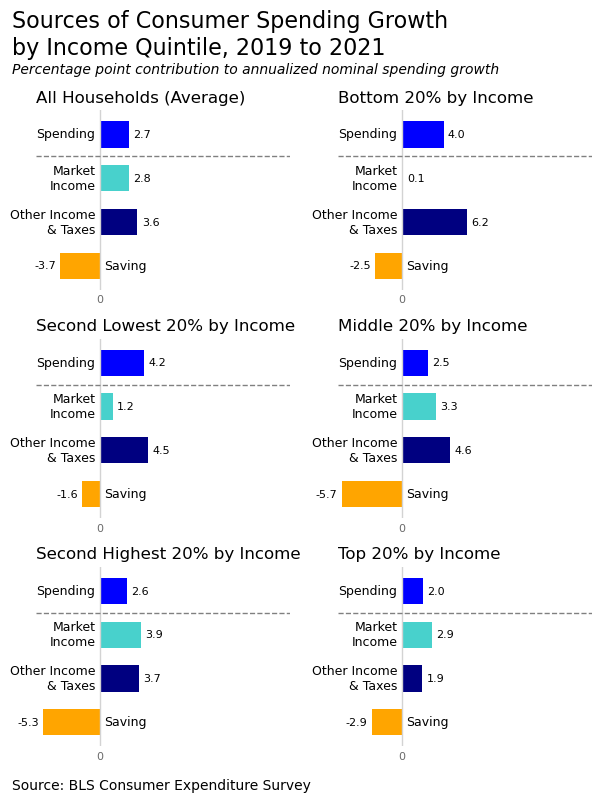

In [8]:
summary_bars(levels, 2021, 2019)

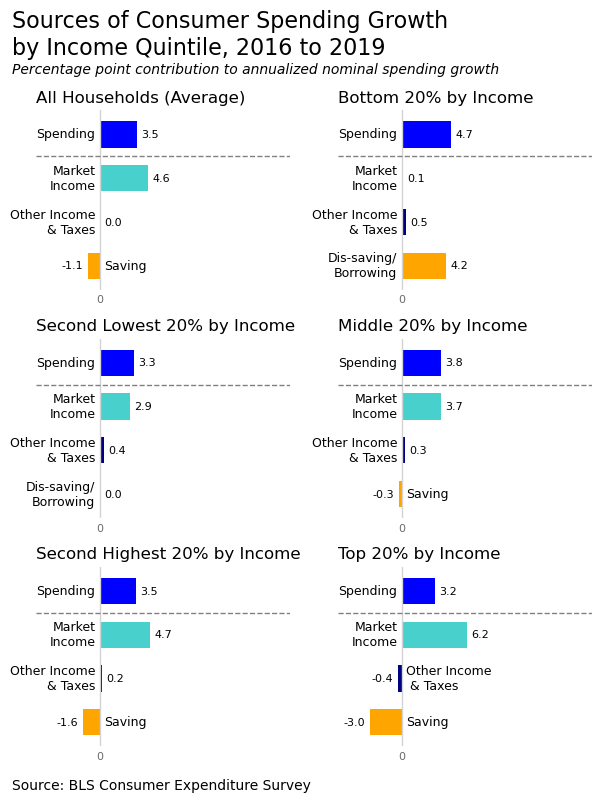

In [7]:
summary_bars(levels, 2019, 2016)

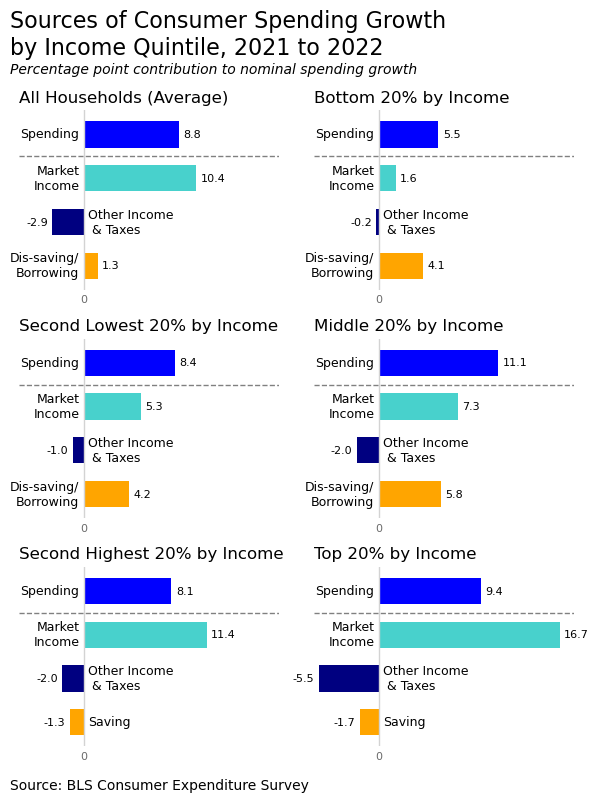

In [9]:
summary_bars(levels, 2022, 2021)

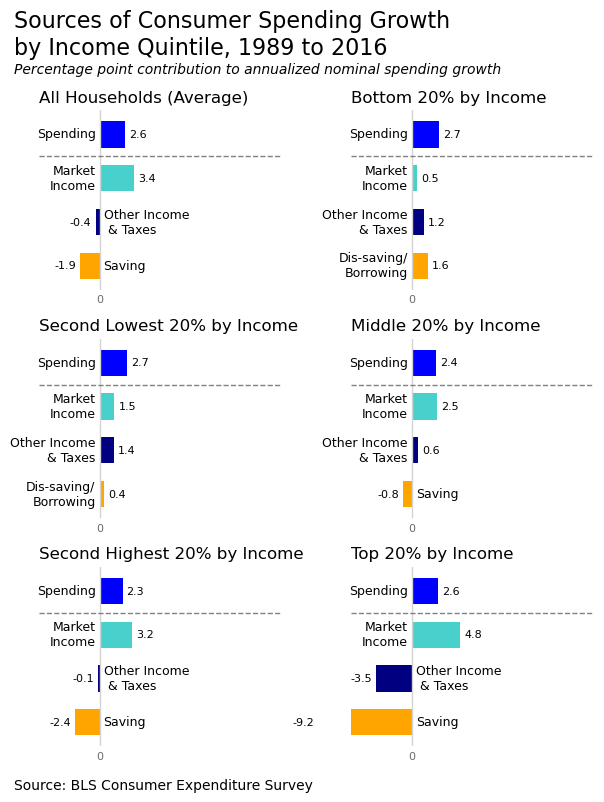

In [12]:
summary_bars(levels, 2016, 1989)